In [1]:
import numpy as np
import pandas as pd
from subprocess import check_output
from sklearn import ensemble, metrics, linear_model
import random
%matplotlib inline

In [3]:
rnd=191989
random.seed(rnd)
n_ft=15 #Number of features to add
max_elts=5

In [4]:
class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd = random_state
        self.n = n_neighbours
        self.max_elts = max_elts
        self.verbose = verbose
        self.neighbours = []
        self.clfs = []
        
    def fit(self, train, y):
        if self.rnd != None:
            random.seed(rnd)
        if self.max_elts == None:
            self.max_elts = len(train.columns)
        list_vars = list(train.columns)
        random.shuffle(list_vars)
        
        lastscores = np.zeros(self.n) + 1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars = list_vars[self.n:]
        
        for elt in list_vars:
            indice = 0
            scores = []
            for elt2 in self.neighbours:
                if len(elt2) < self.max_elts:
                    clf = linear_model.LinearRegression(fit_intercept=False, 
                                                        normalize=True, copy_X=True) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains = lastscores - scores
            if gains.max() > 0:
                temp = gains.argmax()
                lastscores[temp] = scores[temp]
                self.neighbours[temp].append(elt)

        indice = 0
        for elt in self.neighbours:
            clf = linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice = indice + 1
                    
    def transform(self, train):
        indice = 0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)] = self.clfs[indice].predict(train[elt])
            indice = indice + 1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)

In [5]:
train = pd.read_csv("data/train.csv")
#train = pd.read_csv("data/train.csv")
target = train['target'].values
test = pd.read_csv("data/test.csv")
id_test = test['ID'].values

In [6]:
train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 
           'v34', 'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

refcols=list(train.columns)

In [7]:
cat_cols = filter(lambda x: train[x].dtype == 'O', train.columns)
cat_cols

In [8]:
#from __future__ import division

def woe_oof(col, target, cv=None):
    if cv is None:
        cv = [([x for x in range(len(target))], [x for x in range(len(target))])]
    res = np.zeros(col.shape)
    values = col.unique()
    for train, test in cv:
        Xtrain, Xtest = col.iloc[train], col.iloc[test]
        Ytrain, Ytest = target.iloc[train], target.iloc[test]
        mean = Ytrain.sum() / len(Ytrain)
        print(mean)
        woe = dict()
        for val in values:
            try:
                good = Ytrain[Xtrain == val].sum()
                total = Xtrain.value_counts()[val]
                woe[val] =  (total - good) / good
                #print val, total
            except:
                print(val, good, total)
                woe[val] = np.nan
        res[test] = Xtest.apply(lambda x: np.log(woe[x] / mean))
    return res

def woe(train_col, test_col, target):
    res_train, res_test = np.zeros(train_col.shape), np.zeros(test_col.shape)
    values = train_col.unique()
    mean = target.sum() / len(target)
    print(mean)
    woe = dict()
    for val in values:
        try:
            good = target[train_col == val].sum()
            total = train_col.value_counts()[val]
            woe[val] =  (total - good) / good
            #print val, total
        except:
            print(val, good, total)
            woe[val] = np.nan
            
    def get_woe(woe, key):
        try:
            return woe[key]
        except:
            return np.nan
        
    res_train = train_col.apply(lambda x: np.log(woe[x] / mean))
    res_test = test_col.apply(lambda x: np.log(get_woe(woe, x) / mean))
    return res_train, res_test

In [9]:
from sklearn.cross_validation import StratifiedKFold

#cat_n = len(cat_cols)
for cat in filter(lambda x: train[x].dtype == 'O', train.columns):
    if cat == 'v22': continue
    print(cat,)
    w_train, w_test = woe(pd.Series(train[cat]), pd.Series(test[cat]), pd.Series(target))
    train[cat] = pd.Series(w_train)
    test[cat] = pd.Series(w_test)

v3
0.761198729892
v24
0.761198729892
v30
0.761198729892
v31
0.761198729892
v47
0.761198729892
v52
0.761198729892
v56
0.761198729892
v66
0.761198729892
v71
0.761198729892
v74
0.761198729892
v75
0.761198729892
v79
0.761198729892
v107
0.761198729892
v110
0.761198729892
v112
0.761198729892
v113
0.761198729892
v125
0.761198729892


In [10]:
for elt in refcols:
    if train[elt].dtype == 'O':
        #continue
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        #train[train[elt] == 20] = -999
        #test[test[elt] == 20] = -999
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)

In [11]:
train.fillna(-999, inplace=True)
train[train == np.infty] = 999
train[train == np.inf] = 999
train[train == -np.infty] = -9999
train[train == -np.inf] = -9999
test.fillna(-999, inplace=True)
test[test == np.infty] = 999
test[test == np.inf] = 999
test[test == -np.infty] = -9999
test[test == -np.inf] = -9999

In [12]:
#%%time
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

0 0.857947441747 ['v9', 'v126', 'v45', 'v16', 'v55']
1 0.556550758563 ['v53', 'v84', 'v113', 'v22-3', 'v43']
2 0.564113080983 ['v114', 'v50', 'v51', 'v22-4', 'v85']
3 0.548022670012 ['v112', 'v57', 'v93', 'v18', 'v62']
4 0.567154741359 ['v13', 'v74', 'v38', 'v127', 'v87']
5 0.843176525663 ['v130', 'v19', 'v7', 'v20', 'v101']
6 0.731851913148 ['v81', 'v124', 'v36', 'v98', 'v21']
7 0.570019058348 ['v24', 'v123', 'v90', 'v89', 'v115']
8 0.581089411496 ['v37', 'v73', 'v65', 'v102', 'v42']
9 0.740554692248 ['v88', 'v96', 'v58', 'v32', 'v61']
10 1.54864730723 ['v22', 'v107', 'v92', 'v59', 'v28']
11 0.587212090324 ['v117', 'v80', 'v125', 'v69', 'v82']
12 0.605472377498 ['v33', 'v86', 'v60', 'v6', 'v77']
13 1.85301938089 ['v71', 'v12', 'v109', 'v52', 'v27']
14 0.538218399515 ['v119', 'v106', 'v31', 'v3', 'v76']


In [18]:
%%time
это кроссвалскор
mf = 55
md = 35
clf = ensemble.ExtraTreesClassifier(n_estimators=3750, max_features=mf ,criterion='entropy',
                                        min_samples_split=4, max_depth=md, min_samples_leaf=2, 
                                        n_jobs = -1, random_state=rnd)

from sklearn.cross_validation import cross_val_score, StratifiedKFold

score = cross_val_score(clf, train, target, scoring='log_loss', cv=StratifiedKFold(target, 5))

Wall time: 6min 9s


In [ ]:
%%telegram_send Yarrr!
pass

In [20]:
score.mean()

-0.48081045075037709

# -0.48378790400565908

In [10]:
from libtelepot import sendMessage

In [13]:
%%time
preds = list()
mf = 55
md = 35
for rnd in range(1):
    print(rnd, md, mf)
    #sendMessage('Hey, I\'m running your shitty script with seed = {:}, you lazy fucker'.format(rnd))
    clf = ensemble.ExtraTreesClassifier(n_estimators=3750, max_features=mf ,criterion='entropy',
                                        min_samples_split=4, max_depth=md, min_samples_leaf=2, 
                                        n_jobs = -1, random_state=rnd)
    clf.fit(train,target)
    pred_et = clf.predict_proba(test)[:, 1]
    preds.append(pred_et)
    break

0 35 55
CPU times: user 1h 31min 40s, sys: 13.5 s, total: 1h 31min 53s
Wall time: 13min 24s


In [9]:
np.array(preds).mean(axis=0).shape

(114393,)

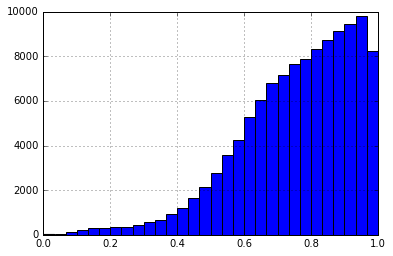

In [14]:
submission=pd.read_csv('data/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=np.array(preds)[0]#.mean(axis=0)
submission.to_csv('submission/et_ln_woe.csv', index=False)
submission.PredictedProb.hist(bins=30)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

 # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

from sklearn import ensemble, metrics, linear_model
import random

#Some parameters to play with
rnd=12
random.seed(rnd)
n_ft=20 #Number of features to add
max_elts=3 #Maximum size of a group of linear features

class addNearestNeighbourLinearFeatures:
    
    def __init__(self, n_neighbours=1, max_elts=None, verbose=True, random_state=None):
        self.rnd=random_state
        self.n=n_neighbours
        self.max_elts=max_elts
        self.verbose=verbose
        self.neighbours=[]
        self.clfs=[]
        
    def fit(self,train,y):
        if self.rnd!=None:
            random.seed(rnd)
        if self.max_elts==None:
            self.max_elts=len(train.columns)
        list_vars=list(train.columns)
        random.shuffle(list_vars)
        
        lastscores=np.zeros(self.n)+1e15

        for elt in list_vars[:self.n]:
            self.neighbours.append([elt])
        list_vars=list_vars[self.n:]
        
        for elt in list_vars:
            indice=0
            scores=[]
            for elt2 in self.neighbours:
                if len(elt2)<self.max_elts:
                    clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
                    clf.fit(train[elt2+[elt]], y)
                    scores.append(metrics.log_loss(y,clf.predict(train[elt2 + [elt]])))
                    indice=indice+1
                else:
                    scores.append(lastscores[indice])
                    indice=indice+1
            gains=lastscores-scores
            if gains.max()>0:
                temp=gains.argmax()
                lastscores[temp]=scores[temp]
                self.neighbours[temp].append(elt)

        indice=0
        for elt in self.neighbours:
            clf=linear_model.LinearRegression(fit_intercept=False, normalize=True, copy_X=True, n_jobs=-1) 
            clf.fit(train[elt], y)
            self.clfs.append(clf)
            if self.verbose:
                print(indice, lastscores[indice], elt)
            indice=indice+1
                    
    def transform(self, train):
        indice=0
        for elt in self.neighbours:
            train['_'.join(pd.Series(elt).sort_values().values)]=self.clfs[indice].predict(train[elt])
            indice=indice+1
        return train
    
    def fit_transform(self, train, y):
        self.fit(train, y)
        return self.transform(train)
    
    
train = pd.read_csv("../input/train.csv")
target = train['target'].values
test = pd.read_csv("../input/test.csv")
id_test = test['ID'].values

train['v22-1']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
test['v22-1']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[0]))
train['v22-2']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
test['v22-2']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[1]))
train['v22-3']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
test['v22-3']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[2]))
train['v22-4']=train['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))
test['v22-4']=test['v22'].fillna('@@@@').apply(lambda x:'@'*(4-len(str(x)))+str(x)).apply(lambda x:ord(x[3]))

drop_list=['v91','v1', 'v8', 'v10', 'v15', 'v17', 'v25', 'v29', 'v34', 'v41', 'v46', 'v54', 'v64', 'v67', 'v97', 'v105', 'v111', 'v122']
train = train.drop(['ID','target'] + drop_list,axis=1).fillna(-999)
test = test.drop(['ID'] + drop_list,axis=1).fillna(-999)

refcols=list(train.columns)

for elt in refcols:
    if train[elt].dtype=='O':
        train[elt], temp = pd.factorize(train[elt])
        test[elt]=temp.get_indexer(test[elt])
    else:
        train[elt]=train[elt].round(5)
        test[elt]=test[elt].round(5)
        
a=addNearestNeighbourLinearFeatures(n_neighbours=n_ft, max_elts=max_elts, verbose=True, random_state=rnd)
a.fit(train, target)

train = a.transform(train)
test = a.transform(test)

clf = ensemble.ExtraTreesClassifier(n_estimators=750,max_features=50,criterion= 'entropy',min_samples_split= 4,
                        max_depth= 35, min_samples_leaf= 2, n_jobs = -1, random_state=rnd)

clf.fit(train,target)
pred_et=clf.predict_proba(test)

submission=pd.read_csv('../input/sample_submission.csv')
submission.index=submission.ID
submission.PredictedProb=pred_et[:,1]
submission.to_csv('./addNNLinearFt.csv', index=False)
submission.PredictedProb.hist(bins=30)